#  Analysis of susceptibility-temperature, <span style="font-family: 'Times New Roman';">*k(T)*</span>, data
-------------------------------------------------------------------------------------------------------------------------

This notebook allows the user to: 

(1) Download a contribution from the MagIC database.

(2) Extract any susceptibility-temperature, <span style="font-family: 'Times New Roman';">*k(T)*</span>, data contained within it.

(3) Correct for the diamagnetic signal of the measurement instrument and holder (if required).

(4) Smooth the data prior to further anaysis (if required).

(5) Calculate Curie Temperatures, <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span>, using first and second-order derivatives.

The notebook is to be run cell-by-cell to allow users to select corrections/filters as needed. The code below runs an example dataset from [Doctor and Feinberg (2022)](https://doi.org/10.1029/2021JB023789), D|ifferential thermal analysis using high temperature susceptibility instruments, *Journal of Geophysical Research: Solid Earth*, which is MagiC contribution [19369](http://dx.doi.org/10.7288/V4/MAGIC/19369). Any MagIC contribution which contains <span style="font-family: 'Times New Roman';">*k(T)*</span> data can be used in place of this example dataset.

**Nota bene:** We do not provide Curie Temperature estimation by the "two-tangent" method, as proposed for spontaneous magnetization  <span style="font-family: 'Times New Roman';">*M<sub>s</sub>(T)*</span> curves by [Grommé et al. (1969)](https://doi.org/10.1029/JB074i022p05277). [Fabian et al. (2013)](https://doi.org/10.1029/2012GC004440) explain this well:

_"The importance of the difference between determining <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> from <span style="font-family: 'Times New Roman';">M<sub>s</sub>(T)</span> and <span style="font-family: 'Times New Roman';">k(T)</span> is pointed out by [Petrovský and Kapicka (2006)](https://doi.org/10.1029/2006JB004507), where methods to determine <span style="font-family: 'Times New Roman';">T<sub>c</sub></span> from measurements of the initial susceptibility are analyzed. They conclude that the two-tangent method is not suitable for <span style="font-family: 'Times New Roman';">k(T)</span> and can considerably overestimate <span style="font-family: 'Times New Roman';">T<sub>c</sub></span>. The physical origin of  <span style="font-family: 'Times New Roman';">k(T)</span> close to <span style="font-family: 'Times New Roman';">T<sub>c</sub></span> is more challenging than that of <span style="font-family: 'Times New Roman';">M<sub>s</sub>(T)</span>, because a number of low-field effects are important for <span style="font-family: 'Times New Roman';">k(T)</span>, but become negligible in the higher fields used to infer <span style="font-family: 'Times New Roman';">M<sub>s</sub>(T)</span>. The variation of <span style="font-family: 'Times New Roman';">m</span> depends not only on the variation of <span style="font-family: 'Times New Roman';">M<sub>s</sub>(H,T)</span> with field  <span style="font-family: 'Times New Roman';">H</span>, it also contains a contribution from a rotation of the ordered moment with respect to an easy magnetization axis, and contributions from thermally activated switching of small independent – but already magnetically ordered – regions (e.g., SP particles). In large bulk material domain-wall movement contributes to <span style="font-family: 'Times New Roman';">k(T)</span> even slightly below  <span style="font-family: 'Times New Roman';">Tc</span>. In nanoparticles the inhomogeneity of <span style="font-family: 'Times New Roman';">M<sub>s</sub></span>, due to the different exchangecoupling of inner and surface atoms, is of additional importance."_

And from [Petrovský and Kapicka (2006)](https://doi.org/10.1029/2006JB004507):

_"...susceptibility for T [to] <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> and T < <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> increases to infinity, and we have to use analytical formulas developed for susceptibility behavior above the Curie point. Here, due to the geometry of the susceptibility curve, the two-tangent method will always yield temperature above the inflection point, which is higher than the temperature at which the substance starts to obey the paramagnetic Curie-Weiss law. The resulting error in <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> (or <span style="font-family: 'Times New Roman';">T<sub>N</sub><sup>1</sup></span>) can be on the order of several degrees to several tens of degrees. Therefore, in the case of temperature dependence of magnetic susceptibility, application of the two-tangent method is not justified."_

Furthermore:

_"In the case of synthetic magnetite and hematite, with sharp Hopkinson peak, the difference between transition
temperatures determined using the two-tangent method and Curie-Weiss paramagnetic law is in the order of some few
degrees. In the case of samples with wide susceptibility maximum and gradual decrease, reflecting e.g., wide distribution
of grain sizes, or in the case of substituted hematite, application of the two-tangent method to susceptibility curves overestimates the transition temperature be several tens of degrees."_


<sup>1</sup>Néel Temperature

Key components here include portions of notebooks, and functions developed for the EarthRef JupyterHub:
https://www2.earthref.org/MagIC/jupyter-notebooks

### 1. Install and import packages

Click inside the cell below, hold shift and then press enter. This will automatically run the script below.

In [1]:
# Import all packages needed for plotting and calculations
!pip install --user plotly
!pip install statsmodels
!pip install jupyter_core

import os
import numpy as np
import pmagpy.ipmag as ipmag
import plotly.express as px
import ipywidgets as widgets
import pandas as pd
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import statsmodels.api as sm
import urllib
import json
import requests
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML, clear_output, Javascript 
from notebook import notebookapp
from statsmodels.nonparametric.smoothers_lowess import lowess

display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

<IPython.core.display.Javascript object>

### 2. Import the data from a MagIC contribution

(1)    Run the following cell by pressing "Import". This will generate a box for you to type in the MagIC Contribution        ID of interest.

(2)    The default is for the dataset of *Doctor and Feinberg (2022)*. MagIC ID = **19369**. But you will want to find the MagIC ID of the study you are interested in and add this in the box below.

(3)    Click on 'Download MagIC File'. This will:

      (a) create a subdirectory to the directory this notebook is saved in and will be given the name of the MagIC ID,     
      e.g., 19369; 

      (b) download the MagIC contribution file, e.g., magic_contribution_19369.txt, to the subdirectory; 

      (c) "unpack" this file to a series of txt files called locations, sites, samples, specimens and measurements.  

In [7]:
import_button = widgets.Button(description="Import")
def import_file(button_click):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
import_button.on_click(import_file)
display(import_button)

Button(description='Import', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Get current notebook path
current_path = os.getcwd()

# Define the default value for magic_id
magic_id = '19369'
magic_file_name = None  # Initialize magic_file_name as None

# Create a text box widget with the default value
magic_id_textbox = widgets.Text(value=magic_id, description='MagIC Contribution ID:',style={'description_width': 'initial'})

# Function to handle changes in the text box value
def update_magic_id(change):
    global magic_id
    magic_id = change.new

# Attach the event handler to the text box
magic_id_textbox.observe(update_magic_id, names='value')

# Display the text box
display(magic_id_textbox)

# Add a button to trigger the download
download_button = widgets.Button(description="Download Magic File")

# Function to handle the button click event and trigger the download
def download_magic_file(button_click):
    global magic_file_name  # Declare magic_file_name as global
    global save_path
    global dpath
    
    #Creates a subdirectory with the name of the magic_id
    subdirectory_name = magic_id
    dpath = os.path.join(current_path, subdirectory_name)
    os.makedirs(dpath, exist_ok=True)
    print(f"Subdirectory created at: {dpath}")
    
    #Downloads the file from MagIC and saves it automatically in the subdirectory
    magic_dlink = "https://earthref.org/MagIC/download/" + magic_id + "/magic_contribution_" + magic_id + ".txt"
#    print(magic_dlink)
#    magic_dlink = "https://earthref.org/MagIC/download/19369/magic_contribution_19369.txt"
    save_name = "magic_contribution_" + magic_id + ".txt"
#    print(save_name)
    save_path = os.path.join(dpath, save_name)
    response = requests.get(magic_dlink)
    with open(save_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded and saved to: {save_path}")
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+2, IPython.notebook.ncells())'))
                
#   unpack the file into locations, sites, samples, specimens, etc 
    ipmag.unpack_magic(save_name, 
                      dpath,
                      dpath)
    
# Attach the event handler to the download button
download_button.on_click(download_magic_file)

# Display the download button
display(download_button)

Text(value='19369', description='MagIC Contribution ID:', style=DescriptionStyle(description_width='initial'))

Button(description='Download Magic File', style=ButtonStyle())

Subdirectory created at: C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769
File downloaded and saved to: C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\magic_contribution_16769.txt


<IPython.core.display.Javascript object>

working on:  'contribution'
1  records written to file  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\contribution.txt
contribution  data put in  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\contribution.txt
working on:  'locations'
1  records written to file  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\locations.txt
locations  data put in  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\locations.txt
working on:  'sites'
53  records written to file  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\sites.txt
sites  data put in  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\sites.txt
working on:  'samples'
53  records written to file  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\samples.txt
samples  data put in  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\samples.txt
working on:  'specimens'
207  records written to file  C:\Users\boss\Documents\GitHub\RockmagPy-notebooks\16769\specimens.txt
specimen

### 3. Select a <span style="font-family: 'Times New Roman';">*k(T)*</span> Specimen
*Creates a dropdown to select specimens with <span style="font-family: 'Times New Roman';">k(T)</span> data.*

In [12]:
specimens = None
spfile = os.path.join(dpath,'specimens.txt')
specimens = pd.read_csv(spfile,sep='\t',header=1)

dfs = pd.DataFrame(specimens)

# Filter DataFrame where method_code equals 'LP-X-T'
filtered_dfs = dfs[dfs['method_codes'].str.contains('LP-X-T')]

# Extract unique values from specimen column
specimen_names = filtered_dfs['specimen'].unique().tolist()

# Create a dropdown widget with these unique values
dropdown = widgets.Dropdown(
    options = specimen_names,
    description = 'Specimen:',
    style = {'description_width': 'initial'}
)

# Define a variable to store the selected value
selected_specimen = specimen_names[0]  # Initialize with the first value

# Define a callback function to update the variable
def on_change(change):
    global selected_specimen
    selected_specimen = change['new']
    print(f"Selected value updated to: {selected_specimen}")
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+2, IPython.notebook.ncells())'))
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+4, IPython.notebook.ncells())'))
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+5, IPython.notebook.ncells())'))
    
# Link the callback function to the dropdown widget
dropdown.observe(on_change, names = 'value')

# Display the dropdown widget
display(dropdown)

# Example usage of the selected_value variable in other code
print(f"Initially selected value: {selected_specimen}")

Dropdown(description='Specimen:', options=('360-U1473A-03R-3-W-116-r4', '360-U1473A-05R-1-W-012-r4', '360-U147…

Initially selected value: 360-U1473A-03R-3-W-116-r4
Selected value updated to: 360-U1473A-84R-1-W-143-r4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 4. Call the measurement data for the selected specimen





In [20]:
# Filter by method code and specimen type
# Split data up into heating and cooling curves

filtered_dfm = None
dfm = None
mfile = os.path.join(dpath,'measurements.txt')

# Read the data from the "measurements.txt" file into a DataFrame
dfm = pd.read_csv(mfile, sep="\t", header=1)

# Filter for k(T) data and the selected specimen name
filtered_dfm = dfm[(dfm['method_codes'].str.contains('LP-X-T')) & (dfm['specimen'] == selected_specimen)]

#Correct automatically for negative susceptibility values - will throw off derivatives and inverse susc calculations
filtered_dfm['susc_chi_mass'].min()
filtered_dfm['susc_chi_mass'] = filtered_dfm['susc_chi_mass']+(filtered_dfm['susc_chi_mass'].min())*-1

if 'meas_temp' not in filtered_dfm:
    filtered_dfm.rename(columns={'treat_temp': 'meas_temp'}, inplace=True)

# Convert temperatures to degrees centigrade
# Add a catch as some people forget to enter the temperatures in Kelvin...

if filtered_dfm['meas_temp'].iloc[0]-273.15 > 0:
    filtered_dfm['meas_temp'] -= 273.15
else:
    filtered_dfm['meas_temp']

# Select only temperature in Kelvin and mass normalized susceptibilty (m3/kg)
kT_all = filtered_dfm[['meas_temp', 'susc_chi_mass']].copy()

# Max temperature
max_T = kT_all['meas_temp'].max()

# Row of max temperature
max_T_step = kT_all.loc[kT_all['meas_temp'] == max_T].index[0]

# Split data into heating and cooling curves, i.e. heating is less than max_T_step and cooling is greater than max_T_step
heat = kT_all.loc[kT_all.index < max_T_step]
cool = kT_all.loc[kT_all.index > max_T_step]

### 5. Plot the heating and cooling <span style="font-family: 'Times New Roman';">*k(T)*</span> curves

In [21]:
# Create a plot for the 'heat' dataset with red points and a line
fig_heat = go.Figure()

# Add heat data as a scatter plot with red points and lines
fig_heat.add_trace(go.Scatter(
    x=heat['meas_temp'],
    y=heat['susc_chi_mass'],
    mode='lines+markers',
    marker=dict(color='red'),
    line=dict(color='red'),
    name='Heating - zero corrected'
))

# Create a scatter plot for the 'cooling' dataset with blue points and a line
fig_cool = go.Figure()

# Add cooling data as a scatter plot with blue points and lines
fig_cool.add_trace(go.Scatter(
    x=cool['meas_temp'],
    y=cool['susc_chi_mass'],
    mode='lines+markers',
    marker=dict(color='blue'),
    line=dict(color='blue'),
    name='Cooling - zero corrected'
))

# Combine the two figures
fig = go.Figure(data=fig_heat.data + fig_cool.data)

width = 900  # Adjust the width to your preference
height = int(width / 1.618)  # Calculate height based on the golden ratio

# Update the layout with a unified title and labels
fig.update_layout(
        title={
        'text': f"{selected_specimen}",
        'x': 0.5,  # Center the title
        'xanchor': 'center'
    },
    width=width,
    height=height,
    xaxis_title='Temperature (&deg;C)',
    yaxis_title='<i>k</i> (m<sup>3</sup> kg<sup>-1</sup>)',
    showlegend=True,
    paper_bgcolor='white',  # Background color of the entire plot
    plot_bgcolor='white',   # Background color of the plotting area
    font=dict(
        family='Roboto, sans-serif',
        size=18,
        color="Black"
    ),
    xaxis=dict(
        tick0=0,  # Start at 0
        dtick=100,  # Tick every 100 units
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show x-axis line
        linewidth=1,  # Width of the x-axis line
        linecolor='black'  # Color of the x-axis line
    ),
    yaxis=dict(
        # Automatic tick marks on the y-axis
        autorange= True,  # Reversed for easier reading
        tickformat='.1e',  # Scientific notation format
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show y-axis line
        linewidth=1,  # Width of the y-axis line
        linecolor='black'  # Color of the y-axis line
    ),
        shapes=[
        # Frame around the plot
        dict(
            type='rect',
            xref='paper', yref='paper',
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color='black', width=2)
        )
    ],
    margin=dict(
        l=50,  # Adjust left margin
        r=50,  # Adjust right margin
        b=50,  # Adjust bottom margin
        t=80   # Adjust top margin for title
    )
)

# Show the combined plot
fig.show()

In [22]:
matplotlib inline

### 6. Running Average Smoothing

Your data might be noisy, which may hinder interpretation of Curie Temperatures or assessing reversibility for understanding alteration. The following code will perform a running average of data over a temperature interval that you can define.

Two graphs will be created. 

(1) The top graph shows the raw data as points and the smoothed data as lines, for the temperature window size selected.

(2) The bottom graphs compares the model roughness against the root mean square error of the model (note that the y-axis is inverted) (a measure of the difference between the running average and the data). Each point on the graph is for a different temperature window size. The knee in the curve (the break of slope) is the optimal tempeature window. At this point (window) there is a decent trade off between the smoothness of the model (the running average) and error on the model.


In [23]:
#Create temperature window box
temp_window = '0.0'

# Create a text box widget for the LOESS smoothing fraction
temp_window_textbox = widgets.Text(value=temp_window, description='Temperature window size', style={'description_width': 'initial'})

# Add descriptive text next to the text box
description_label = widgets.Label(value='\u00B0C')
description_box = widgets.HBox([temp_window_textbox, description_label])

# Function to handle changes in the text box value
def handle_textbox_change(change):
    new_value = change.new
    if new_value.strip() != '':
        global temp_window
        temp_window = new_value

# Attach the event handler to monitor changes in the text box value
temp_window_textbox.observe(handle_textbox_change, names='value')

# Function to execute code when button is clicked
def execute_code(button):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

# Create a button widget for executing code
execute_button = widgets.Button(description='Smooth')

# Attach the event handler to the button
execute_button.on_click(execute_code)

# Display the text box, button, and descriptive text
display(description_box)
display(execute_button)


Button(description='Smooth', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

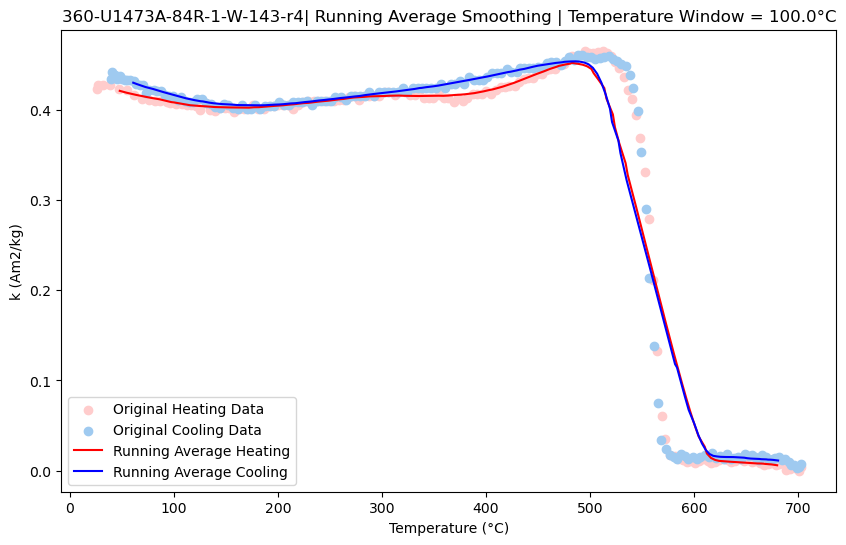

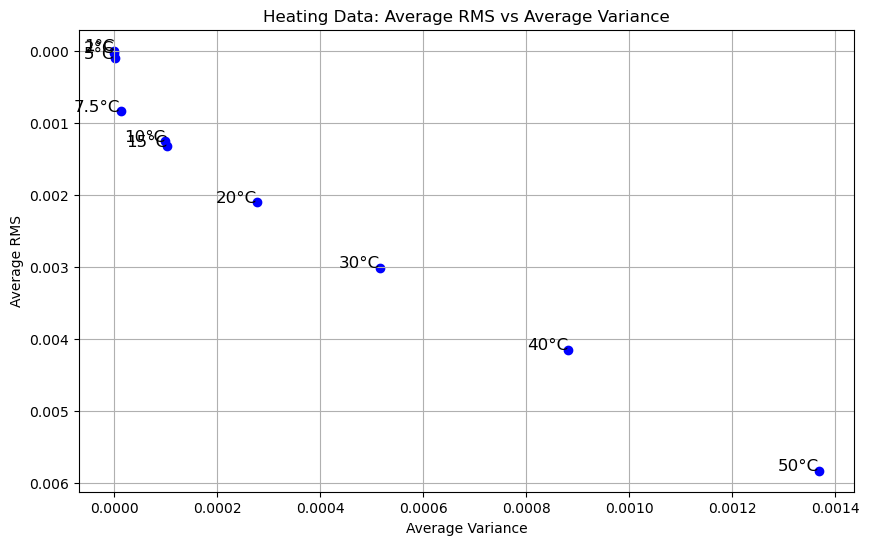

In [38]:
temp_window = float(temp_window)

def running_average(temp_list, chi_list, temp_window):
    if not temp_list or not chi_list or temp_window <= 0:
        return temp_list, chi_list, [], []
    
    avg_temps = []
    avg_chis = []
    temp_vars = []
    chi_vars = []
    n = len(temp_list)
    
    for i in range(n):
        # Determine the temperature range for the current point
        temp_center = temp_list[i]
        start_temp = temp_center - temp_window / 2
        end_temp = temp_center + temp_window / 2
        
        # Get the indices within the temperature range
        indices = [j for j, t in enumerate(temp_list) if start_temp <= t <= end_temp]
        
        # Calculate the average temperature and susceptibility for the current window
        if indices:
            temp_range = [temp_list[j] for j in indices]
            chi_range = [chi_list[j] for j in indices]
            avg_temp = sum(temp_range) / len(temp_range)
            avg_chi = sum(chi_range) / len(chi_range)
            temp_var = np.var(temp_range)
            chi_var = np.var(chi_range)
        else:
            avg_temp = temp_center
            avg_chi = chi_list[i]
            temp_var = 0
            chi_var = 0
        
        avg_temps.append(avg_temp)
        avg_chis.append(avg_chi)
        temp_vars.append(temp_var)
        chi_vars.append(chi_var)
    
    return avg_temps, avg_chis, temp_vars, chi_vars

# From heating
hT = heat['meas_temp'].tolist()
hk = heat['susc_chi_mass'].tolist()

# From cooling
cT = cool['meas_temp'].tolist()
ck = cool['susc_chi_mass'].tolist()

avg_temp_heat, avg_chi_heat, temp_vars, chi_vars = running_average(hT, hk, temp_window)
avg_temp_cool, avg_chi_cool, temp_vars, chi_vars = running_average(cT, ck, temp_window)

def calculate_rms(chi_list, avg_chis):
    mse = [(chi - avg_chi)**2 for chi, avg_chi in zip(chi_list, avg_chis)]
    rms = np.sqrt(mse)
    return rms

def calculate_avg_variance_and_rms(chi_list, avg_chis, temp_vars, chi_vars):
    rms_list = calculate_rms(chi_list, avg_chis)
    total_rms = np.sum(rms_list)
    avg_rms = total_rms / len(rms_list)
    
    total_variance = np.sum(chi_vars)
    avg_variance = total_variance / len(chi_vars)
    
    return avg_rms, avg_variance

def evaluate_window_sizes(temp_list, chi_list, window_sizes):
    results = []
    for window_size in window_sizes:
        avg_temps, avg_chis, temp_vars, chi_vars = running_average(temp_list, chi_list, window_size)
        avg_rms, avg_variance = calculate_avg_variance_and_rms(chi_list, avg_chis, temp_vars, chi_vars)
        results.append((window_size, avg_rms, avg_variance))
    return results

# Define the range of window sizes to evaluate
window_sizes = [1, 2, 5, 7.5, 10, 15, 20, 30, 40, 50]

# Evaluate for heating data
results_heat = evaluate_window_sizes(hT, hk, window_sizes)

# Evaluate for cooling data
results_cool = evaluate_window_sizes(cT, ck, window_sizes)

plt.figure(figsize=(10, 6))
plt.scatter(hT, hk, label='Original Heating Data', color='#FFCCCC')
plt.scatter(cT, ck, label='Original Cooling Data', color='#9FCAF0')
plt.plot(avg_temp_heat, avg_chi_heat, label='Running Average Heating', color='Red')
plt.plot(avg_temp_cool, avg_chi_cool, label='Running Average Cooling', color='Blue')
plt.xlabel('Temperature (\u00B0C)')
plt.ylabel('k (Am2/kg)')
plt.title(selected_specimen + '| Running Average Smoothing | Temperature Window = ' + str(temp_window) + '\u00B0C')
plt.legend()
plt.show()


def plot_rms_vs_variance(results, title):
    window_sizes, rmses, variances = zip(*results)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(variances, rmses, color='blue')
    
    for i, window_size in enumerate(window_sizes):
        plt.text(variances[i], rmses[i], f'{window_size}°C', fontsize=12, ha='right')
    
    plt.title(title)
    plt.xlabel('Average Variance')
    plt.ylabel('Average RMS')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

# Plot for heating data
plot_rms_vs_variance(results_heat, 'Heating Data: Average RMS vs Average Variance')

### 7. Plot the first and second derivatives of the <span style="font-family: 'Times New Roman';">*k(T)*</span> data

Plotting the first and second derviatives of the data can help define practical Curie Temperatures for the phases in a specimen. For the first derviative one looks for the maximum in the derivative. In the second derivative, one looks for the zero crossing points. The second derivative can often be noisy and hard to work with. NB. The temperatures defined this way are only an estimate of the Curie Temperature.

In [39]:
#Created dataframes from the smoothed data

df_hsmoothed = pd.DataFrame({
    'temp': avg_temp_heat,
    'susc': avg_chi_heat
})

df_csmoothed = pd.DataFrame({
    'temp': avg_temp_cool,
    'susc': avg_chi_cool
})

# ----------------------------------------------------------------------------------------------------------------
# Calculate first order derivative
df_hsmoothed['first_derivative_susc'] = df_hsmoothed['susc'].diff()
df_hsmoothed['first_derivative_temp'] = df_hsmoothed['temp'].diff()
df_hsmoothed['first_derivative_kT'] = df_hsmoothed['first_derivative_susc']/df_hsmoothed['first_derivative_temp']
df_hsmoothed['first_derivative_tstep'] = df_hsmoothed['temp']+(df_hsmoothed['first_derivative_temp']/2)

df_csmoothed['first_derivative_susc'] = df_csmoothed['susc'].diff()
df_csmoothed['first_derivative_temp'] = df_csmoothed['temp'].diff()
df_csmoothed['first_derivative_kT'] = df_csmoothed['first_derivative_susc']/df_csmoothed['first_derivative_temp']
df_csmoothed['first_derivative_tstep'] = df_csmoothed['temp']+(df_csmoothed['first_derivative_temp']/2)

# Create a plot for the 'heat' dataset with red points and a line
fig_dheat = go.Figure()

# Add heat data as a scatter plot with red points and lines
fig_dheat.add_trace(go.Scatter(
    x=df_hsmoothed['first_derivative_tstep'],
    y=df_hsmoothed['first_derivative_kT'],
    mode='lines+markers',
    marker=dict(color='red'),
    line=dict(color='red'),
    name='Heating (smoothed) - 1st Derivative'
))

# Create a scatter plot for the 'cooling' dataset with blue points and a line
fig_dcool = go.Figure()

# Add cooling data as a scatter plot with blue points and lines
fig_dcool.add_trace(go.Scatter(
    x=df_csmoothed['first_derivative_tstep'],
    y=df_csmoothed['first_derivative_kT'],
    mode='lines+markers',
    marker=dict(color='blue'),
    line=dict(color='blue'),
    name='Cooling (smoothed) - 1st Derivative'
))

# Combine the two figures
fig = go.Figure(data=fig_dheat.data + fig_dcool.data)

width = 900  # Adjust the width to your preference
height = int(width / 1.618)  # Calculate height based on the golden ratio

# Update the layout with a unified title and labels
fig.update_layout(
        title={
        'text': f"{selected_specimen}",
        'x': 0.5,  # Center the title
        'xanchor': 'center'
    },
    width=width,
    height=height,
    xaxis_title='Temperature (&deg;C)',
    yaxis_title='<i>dk/dT</i> (m<sup>3</sup> kg<sup>-1</sup>)',
    showlegend=True,
    paper_bgcolor='white',  # Background color of the entire plot
    plot_bgcolor='white',   # Background color of the plotting area
    font=dict(
        family='Roboto, sans-serif',
        size=18,
        color="Black"
    ),
    xaxis=dict(
        tick0=0,  # Start at 0
        dtick=100,  # Tick every 100 units
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show x-axis line
        linewidth=1,  # Width of the x-axis line
        linecolor='black'  # Color of the x-axis line
    ),
    yaxis=dict(
        # Automatic tick marks on the y-axis
        autorange= True,  # Reversed for easier reading
        tickformat='.1e',  # Scientific notation format
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show y-axis line
        linewidth=1,  # Width of the y-axis line
        linecolor='black'  # Color of the y-axis line
    ),
        shapes=[
        # Frame around the plot
        dict(
            type='rect',
            xref='paper', yref='paper',
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color='black', width=2)
        )
    ],
    margin=dict(
        l=50,  # Adjust left margin
        r=50,  # Adjust right margin
        b=50,  # Adjust bottom margin
        t=80   # Adjust top margin for title
    )
)

# Plot first order derviative
fig.show()

# -----------------------------------------------------------------------------------------------------------------
# Calculate second order derivative
df_hsmoothed['second_derivative_susc'] = df_hsmoothed['susc'].diff().diff()
df_hsmoothed['second_derivative_temp'] = df_hsmoothed['temp'].diff().diff()
df_hsmoothed['second_derivative_kT'] = df_hsmoothed['second_derivative_susc']/df_hsmoothed['second_derivative_temp']
df_hsmoothed['second_derivative_tstep'] = df_hsmoothed['temp']+(df_hsmoothed['first_derivative_temp']/2)

df_csmoothed['second_derivative_susc'] = df_csmoothed['susc'].diff().diff()
df_csmoothed['second_derivative_temp'] = df_csmoothed['temp'].diff().diff()
df_csmoothed['second_derivative_kT'] = df_csmoothed['second_derivative_susc']/df_csmoothed['second_derivative_temp']
df_csmoothed['second_derivative_tstep'] = df_csmoothed['temp']+(df_csmoothed['first_derivative_temp']/2)

# Create a plot for the 'heat' dataset with red points and a line
fig_d2heat = go.Figure()

# Add heat data as a scatter plot with red points and lines
fig_d2heat.add_trace(go.Scatter(
    x=df_hsmoothed['second_derivative_tstep'],
    y=df_hsmoothed['second_derivative_kT'],
    mode='lines+markers',
    marker=dict(color='red'),
    line=dict(color='red'),
    name='Heating (smoothed) - 2nd Derivative'
))

# Create a scatter plot for the 'cooling' dataset with blue points and a line
fig_d2cool = go.Figure()

# Add cooling data as a scatter plot with blue points and lines
fig_d2cool.add_trace(go.Scatter(
    x=df_csmoothed['second_derivative_tstep'],
    y=df_csmoothed['second_derivative_kT'],
    mode='lines+markers',
    marker=dict(color='blue'),
    line=dict(color='blue'),
    name='Cooling (smoothed) - 2nd Derivative'
))

# Combine the two figures
figd2 = go.Figure(data=fig_d2heat.data + fig_d2cool.data)

width = 900  # Adjust the width to your preference
height = int(width / 1.618)  # Calculate height based on the golden ratio

# Update the layout with a unified title and labels
figd2.update_layout(
        title={
        'text': f"{selected_specimen}",
        'x': 0.5,  # Center the title
        'xanchor': 'center'
    },
    width=width,
    height=height,
    xaxis_title='Temperature (&deg;C)',
    yaxis_title='<i>dk/dT</i> (m<sup>3</sup> kg<sup>-1</sup>)',
    showlegend=True,
    paper_bgcolor='white',  # Background color of the entire plot
    plot_bgcolor='white',   # Background color of the plotting area
    font=dict(
        family='Roboto, sans-serif',
        size=18,
        color="Black"
    ),
    xaxis=dict(
        tick0=0,  # Start at 0
        dtick=100,  # Tick every 100 units
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show x-axis line
        linewidth=1,  # Width of the x-axis line
        linecolor='black'  # Color of the x-axis line
    ),
    yaxis=dict(
        # Automatic tick marks on the y-axis
        autorange= True,  # Reversed for easier reading
        tickformat='.1e',  # Scientific notation format
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show y-axis line
        linewidth=1,  # Width of the y-axis line
        linecolor='black'  # Color of the y-axis line
    ),
        shapes=[
        # Frame around the plot
        dict(
            type='rect',
            xref='paper', yref='paper',
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color='black', width=2)
        )
    ],
    margin=dict(
        l=50,  # Adjust left margin
        r=50,  # Adjust right margin
        b=50,  # Adjust bottom margin
        t=80   # Adjust top margin for title
    )
)

# Plot first order derviative
figd2.show()

### 8. Calculate <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> using inverse susceptibility

Above <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> a mineral phase will be paramagnetic. This means that the inverse susceptibility should have a linear positive slope above <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span>. Using the intercept temperature at 0 inverse susceptibility is a good guess for  <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span>. This is essentially the break of slope between the ferromagnetic and paramagnetic signal.

In [40]:
df_hsmoothed['inverse_susc'] = 1/df_hsmoothed['susc']

# Create a plot for the 'heat' dataset with red points and a line
fig_iheat = go.Figure()

# Add heat data as a scatter plot with red points and lines
fig_iheat.add_trace(go.Scatter(
    x=df_hsmoothed['temp'],
    y=df_hsmoothed['inverse_susc'],
    mode='lines+markers',
    marker=dict(color='red'),
    line=dict(color='red'),
    name='Heating (smoothed) - Inverse'
))

fig_iheat.update_layout(
        title={
        'text': f"{selected_specimen}",
        'x': 0.5,  # Center the title
        'xanchor': 'center'
    },
    width=width,
    height=height,
    xaxis_title='Temperature (&deg;C)',
    yaxis_title='Inverse <i>k</i> (m<sup>-3</sup> kg<sup>1</sup>)',
    showlegend=True,
    paper_bgcolor='white',  # Background color of the entire plot
    plot_bgcolor='white',   # Background color of the plotting area
    font=dict(
        family='Roboto, sans-serif',
        size=18,
        color="Black"
    ),
    xaxis=dict(
        tick0=0,  # Start at 0
        dtick=100,  # Tick every 100 units
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show x-axis line
        linewidth=1,  # Width of the x-axis line
        linecolor='black'  # Color of the x-axis line
    ),
    yaxis=dict(
        # Automatic tick marks on the y-axis
        autorange= True,  # Reversed for easier reading
        tickformat='.1e',  # Scientific notation format
        gridcolor='lightgray',  # Color of the grid lines
        gridwidth=1,  # Width of the grid lines
        showline=True,  # Show y-axis line
        linewidth=1,  # Width of the y-axis line
        linecolor='black'  # Color of the y-axis line
    ),
        shapes=[
        # Frame around the plot
        dict(
            type='rect',
            xref='paper', yref='paper',
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color='black', width=2)
        )
    ],
    margin=dict(
        l=50,  # Adjust left margin
        r=50,  # Adjust right margin
        b=50,  # Adjust bottom margin
        t=80   # Adjust top margin for title
    )
)

# Plot first order derviative
fig_iheat.show()